<a href="https://colab.research.google.com/github/apoorvyadav1111/Machine-Learning-Practice/blob/master/Generative%20Adversarial%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Link to the tensorflow tutorial: https://www.tensorflow.org/tutorials/generative/dcgan

In [ ]:
!pip install -q imageio

In [ ]:
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
import glob
from tensorflow.keras import layers
import PIL
import time

from IPython import display

In [ ]:
(X,y),(_,_) = tf.keras.datasets.mnist.load_data()
X.shape

11493376/11490434 [==============================] - 1s 0us/step


(60000, 28, 28)

In [ ]:
X = X.reshape(X.shape[0],28,28,1)
X = (X-127.5)/127.5

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
X = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256,use_bias = False,input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape == ((None,7,7,256))
  
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias = False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=True))
  assert model.output_shape == (None,28,28,1)
  return model

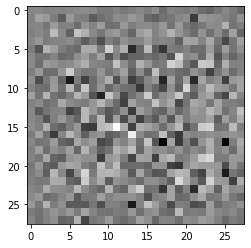

In [ ]:
gen = make_generator()

noise = tf.random.normal([1,100])
img = gen(noise,training=False)

plt.imshow(img[0,:,:,0],cmap='gray')

In [ ]:
def make_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides = (2,2),padding='same',input_shape = [28,28,1]))
  
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model
dis = make_discriminator()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def discriminator_loss(real,fake):
  reall = cross_entropy(tf.ones_like(real),real)
  fakel = cross_entropy(tf.zeros_like(fake),fake)
  totall = reall+fakel
  return totall

def generator_loss(fake):
  return cross_entropy(tf.ones_like(fake),fake)

In [ ]:
gen_opt = tf.keras.optimizers.Adam(1e-4)
dis_opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = gen_opt,
                                 discriminator_optimizer = dis_opt,
                                 generator = gen,
                                 discriminator = dis
                                 )

In [ ]:
EPOCHS = 50
noise_dim = 100
num_example_to_generate = 16

seed = tf.random.normal([num_example_to_generate,noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE,noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    gen_image = gen(noise,training = True)
    real = dis(images,training = True)
    fake = dis(gen_image,training=True)

    gen_loss = generator_loss(fake)
    dis_loss = discriminator_loss(real,fake)

  gen_grad = gen_tape.gradient(gen_loss,gen.trainable_variables)
  dis_grad = dis_tape.gradient(dis_loss,dis.trainable_variables)

  gen_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
  dis_opt.apply_gradients(zip(dis_grad,dis.trainable_variables))
    

In [ ]:
def train(dataset,epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(gen,
                             epoch + 1,
                             seed)
    
    if (epoch+1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait = True)
  generate_and_save_images(gen,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

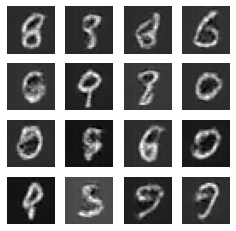

In [ ]:
train(X,EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)